<a href="https://colab.research.google.com/github/ravit-cohen-segev/cats/blob/master/mirrori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#writer Ravit Cohen-Segev

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, concatenate, LeakyReLU, ReLU, Layer, UpSampling2D
from tensorflow.keras import Model
from tensorflow import pad
import tensorflow_datasets as tfds

import os
import numpy as np
import cv2
import PIL
import PIL.Image
import pathlib
from google.colab.patches import cv2_imshow


In [40]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
#parameters for creating noisy images 
sigma=30
mean=0

#create noisy dataset
def create_noisy_images(mean, images, sigma):
    noisy_images = []
    for img in images:
      #add gaussian noise
      gaussian = np.random.normal(mean, sigma, (img.shape))
      gaussian = gaussian.reshape(img.shape)
      img_with_noise = img + gaussian
      #scale noisy image and append to list
      noisy_images.append(img_with_noise)
    return noisy_images

In [42]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding, **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'REFLECT')


In [43]:
class Denoiser():
    def __init__(self):
        pass
    
    def build_hourglass(self, input_shape, optimizer, interpolation):
        ''' params used for network: n_u = [128, 128, 128, 128, 128], n_d = [128, 128, 128, 128, 128],
        kernel size = (3,3) for downsampling and upsampling, k_d, k_u = [3, 3, 3, 3, 3],n_skip = [4, 4, 4, 4, 4],
        k_skip = [1, 1, 1, 1, 1]'''

        #build encoder
        #initialize weights
        initializer = tf.keras.initializers.RandomNormal()
        d_input = Input(shape=input_shape, name='Input_encoder')
        d_1 = Conv2D(128, (3,3), activation=ReLU(), kernel_initializer=initializer, name='denoising1')(d_input)
        d_2 = Conv2D(128, (3, 3), activation=ReLU(), name='denoising2')(d_1)
        d_3 = Conv2D(128, (3, 3), activation=ReLU(), name='denoising3')(d_2)
        d_4 = Conv2D(128, (3, 3), activation=ReLU(), name='denoising4')(d_3)
        d_output = Conv2D(128, (3, 3), name='denoising5')(d_4)

        #build decoder   
        s_5 = Conv2D(4, (1,1), name='skip_5')(d_output)
        u_4_i = Conv2D(128, (3,3), activation=LeakyReLU(), name='upsampling_5')(s_5)
        u_4_p = ReflectionPadding2D(padding=(2,2))(u_4_i)
        s_4 = Conv2D(4, (1,1), name='skip_4')(d_4)
        u_s_4 = concatenate([u_4_p, s_4], axis=-1)
        u_3_i = Conv2D(128, (3, 3), activation=LeakyReLU(), name='upsampling_4')(u_s_4)
        u_3_p = ReflectionPadding2D(padding=(2,2))(u_3_i)
        s_3 = Conv2D(4, (1, 1), name='skip_3')(d_3)
        u_s_3 = concatenate([u_3_p, s_3], axis=-1)
        u_2_i = Conv2D(128, (3, 3), activation=LeakyReLU(), name='upsampling_3')(u_s_3)
        u_2_p = ReflectionPadding2D(padding=(2,2))(u_2_i)
        s_2 = Conv2D(4, (1, 1), name='skip_2')(d_2)
        u_s_2 = concatenate([u_2_p, s_2], axis=-1)
        u_1_i = Conv2D(128, (3, 3), activation=LeakyReLU(), name='upsampling_2')(u_s_2)
        u_1_p = ReflectionPadding2D(padding=(2,2))(u_1_i)
        s_1 = Conv2D(4, (1, 1), name='skip_1')(d_1)
        u_s_1 = concatenate([u_1_p, s_1], axis=-1)
        u_1_rp = ReflectionPadding2D(padding=(2,2))(u_s_1)
        u_1 = Conv2D(128, (3, 3), activation=LeakyReLU(), name='upsampling_1')(u_1_rp)
        u_output = Dense(3, activation='sigmoid')(u_1)


        autoencoder_model = Model(inputs=d_input, outputs=u_output, name="autoencoder")
        loss_fn = tf.keras.losses.MeanSquaredError()
        autoencoder_model.compile(loss=loss_fn, optimizer=optimizer)
        return autoencoder_model

    def train(self, x_train, y_train, x_test, y_test, shape, num_iter, lr, batch_size,
              upsampling, optimizer):
        
        #build model
        model = self.build_hourglass(input_shape=(shape[0], shape[1], 3), optimizer=optimizer, interpolation=upsampling)
        # Create a callback that saves the model's weights every 5 epochs
        checkpoint_dir = r'/content/gdrive/MyDrive/Colab Notebooks/model-mirrori'
        checkpoint_path = os.path.join(checkpoint_dir,"denoiser.ckpt")
       
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=5*batch_size) 
   
        # Save the weights using the `checkpoint_path` format
        model.save_weights(checkpoint_path.format(epoch=0))
        
        model.fit(x_train, y_train, batch_size=batch_size, epochs=num_iter, validation_split=0.2, callbacks=cp_callback) # Pass callback to training
        model.save_weights(checkpoint_path)
        model.evaluate(x_test, y_test)
        return model


In [ ]:
if __name__=="__main__":
    np.random.seed(42)
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

    #load snail image
    snail_image = cv2.imread(r"C:\Users\ravit\PycharmProject\mirrori\snail.jpg")
    #expand dimensions to image
    #snail_image = np.expand_dims(snail_image, axis=0)
    denoise = Denoiser()
   

In [ ]:
img = [cv2.imread(r'/content/data/snail.jpg').astype('float')]

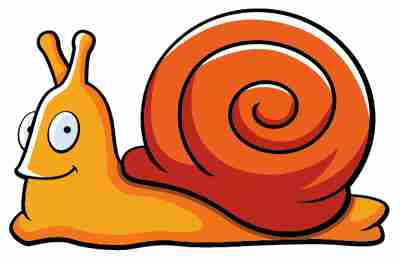

In [ ]:
cv2_imshow(img[0])

In [ ]:
noisy_snail = create_noisy_images(mean, img, sigma)

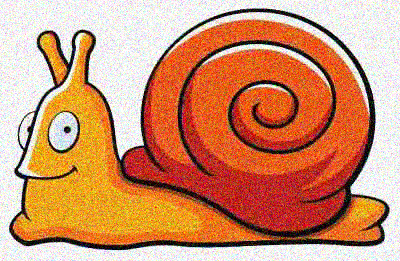

In [ ]:
cv2_imshow(noisy_snail[0])

In [ ]:
#download flowers dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


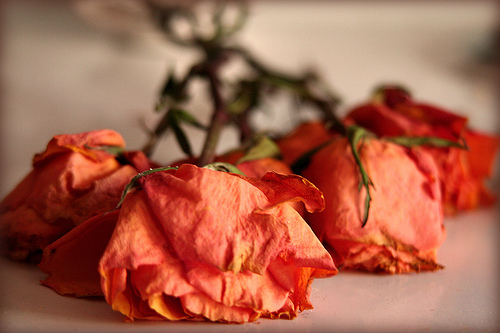

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [44]:
new_size = (128,128)
#convert 32 PIL images to arrays, scale to values between 0 and 1, and contain in list
roses_arrays = [np.asarray(PIL.Image.open(str(rose)).resize(new_size))/255 for rose in roses[:32]] 

In [45]:
#create noisy rose images for input
noisy_roses = create_noisy_images(mean, roses_arrays, sigma)

#scale noisy images between 0 and 1
noisy_roses = [noisy/255 for noisy in noisy_roses] 

In [ ]:
#split dataset to train test 
len_roses = len(roses_arrays)
permuted_idx = np.random.permutation(np.arange(len_roses))
cutoff_idx =  int(0.8*len_roses)
train_idx = permuted_idx[:cutoff_idx]
test_idx = permuted_idx[cutoff_idx:]

X_train = np.array([noisy_roses[i] for i in train_idx])
y_train = np.array([roses_arrays[i] for i in train_idx])

X_test = np.array([noisy_roses[i] for i in test_idx])
y_test = np.array([roses_arrays[i] for i in test_idx])

In [ ]:
X_train.shape

(25, 128, 128, 3)

In [ ]:
#build the model 
denoise = Denoiser()
denoise_model = denoise.build_hourglass((256,256,3), 'adam', 'bilinear')

In [ ]:
denoise_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_encoder (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
denoising1 (Conv2D)             (None, 254, 254, 128 3584        Input_encoder[0][0]              
__________________________________________________________________________________________________
denoising2 (Conv2D)             (None, 252, 252, 128 147584      denoising1[0][0]                 
__________________________________________________________________________________________________
denoising3 (Conv2D)             (None, 250, 250, 128 147584      denoising2[0][0]                 
________________________________________________________________________________________

In [ ]:
model = denoise.train(X_train, y_train, X_test, y_test, shape=new_size, num_iter=50, lr=0.01, batch_size=8, upsampling='bilinear', optimizer='adam')

Epoch 1/50
3/3 [==============================] - 51s 15s/step - loss: 0.0912 - val_loss: 0.0674
Epoch 2/50
3/3 [==============================] - 48s 15s/step - loss: 0.0829 - val_loss: 0.0651
Epoch 3/50
3/3 [==============================] - 48s 15s/step - loss: 0.0776 - val_loss: 0.0616
Epoch 4/50
3/3 [==============================] - 48s 15s/step - loss: 0.0828 - val_loss: 0.0640
Epoch 5/50
3/3 [==============================] - 48s 15s/step - loss: 0.0802 - val_loss: 0.0654
Epoch 6/50
3/3 [==============================] - 48s 15s/step - loss: 0.0798 - val_loss: 0.0598
Epoch 7/50
3/3 [==============================] - 48s 15s/step - loss: 0.0791 - val_loss: 0.0582
Epoch 8/50
3/3 [==============================] - 49s 16s/step - loss: 0.0778 - val_loss: 0.0605
Epoch 9/50
3/3 [==============================] - 48s 15s/step - loss: 0.0781 - val_loss: 0.0622
Epoch 10/50
3/3 [==============================] - 48s 15s/step - loss: 0.0783 - val_loss: 0.0612
Epoch 11/50
3/3 [============

In [91]:
#This section was written after training and saving weights in drive
#In this section I tested the model performance on a noisy image of an airplane. 

#first build the model 
denoise = Denoiser()
denoise_model = denoise.build_hourglass((256,256,3), 'adam', 'bilinear')

#load model weights
checkpoint_dir = r'/content/gdrive/MyDrive/Colab Notebooks/model-mirrori'
checkpoint_path = os.path.join(checkpoint_dir,"denoiser.ckpt")
denoise_model.load_weights(checkpoint_path)

#predict on a sample picture
sample = np.asarray(PIL.Image.open(r"/content/data/F16_GT.png").resize((256,256)))/255
#expand dims
sample = sample.reshape((1, sample.shape[0], sample.shape[1], sample.shape[2]))
noisy_sample = create_noisy_images(mean, [sample], sigma)
test_outcome = denoise_model.predict(noisy_sample)





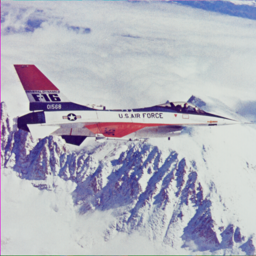

In [92]:
#show original image
PIL.Image.open(r"/content/data/F16_GT.png").resize((256,256))

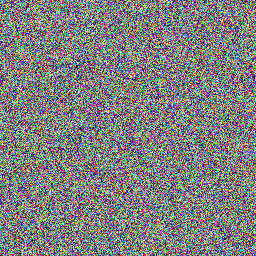

In [99]:
#show noisy image
PIL.Image.fromarray(np.uint8(noisy_sample[0].reshape(256,256,3)*255))

In [100]:
test_outcome = test_outcome.reshape((256,256,3))

In [82]:
test_outcome.shape

(256, 256, 3)

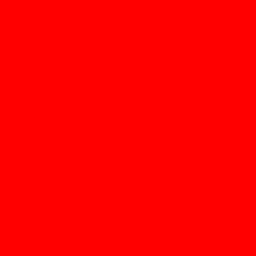

In [87]:
#show outcome from denoiser network. As expected results were not optimal due to less training.
PIL.Image.fromarray(np.uint8(test_outcome*255))